# Advanced predictive models using Machine Learning
## Loading the dataset
Load some bank marketing data and try to predict if the client will subscribe to a term deposit (variable `y`).

In [63]:
using MLJ, CSV, DataFrames, Random, Logging, Plots
Logging.disable_logging(Logging.Warn)

LogLevel(1001)

In [64]:
# Use to log errors
@error "I'm an error"

┌ Error: I'm an error
└ @ Main In[64]:2


Load bank marketing data and inspect it.

In [65]:
df = CSV.read("bank-additional-full.csv", DataFrame, delim=";")

Row,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
,Int64,String15,String15,String31,String7,String7,String7,String15,String3,String3,Int64,Int64,Int64,Int64,String15,Float64,Float64,Float64,Float64,Float64,String3
1,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


MLJ uses "scientific types", which specify how features should be interpreted by the ML models.

In [66]:
schema(df)

┌────────────────┬────────────┬──────────┐
│ names          │ scitypes   │ types    │
├────────────────┼────────────┼──────────┤
│ age            │ Count      │ Int64    │
│ job            │ Textual    │ String15 │
│ marital        │ Textual    │ String15 │
│ education      │ Textual    │ String31 │
│ default        │ Textual    │ String7  │
│ housing        │ Textual    │ String7  │
│ loan           │ Textual    │ String7  │
│ contact        │ Textual    │ String15 │
│ month          │ Textual    │ String3  │
│ day_of_week    │ Textual    │ String3  │
│ duration       │ Count      │ Int64    │
│ campaign       │ Count      │ Int64    │
│ pdays          │ Count      │ Int64    │
│ previous       │ Count      │ Int64    │
│ poutcome       │ Textual    │ String15 │
│ emp.var.rate   │ Continuous │ Float64  │
│ cons.price.idx │ Continuous │ Float64  │
│ cons.conf.idx  │ Continuous │ Float64  │
│ euribor3m      │ Continuous │ Float64  │
│ nr.employed    │ Continuous │ Float64  │
│ y        

Coerce scientific types to be what we want.

In [67]:
df = coerce(df, :age => Continuous, Textual => Multiclass)
df = coerce(df, :y => OrderedFactor)
schema(df)

┌────────────────┬──────────────────┬────────────────────────────────────┐
│ names          │ scitypes         │ types                              │
├────────────────┼──────────────────┼────────────────────────────────────┤
│ age            │ Continuous       │ Float64                            │
│ job            │ Multiclass{12}   │ CategoricalValue{String15, UInt32} │
│ marital        │ Multiclass{4}    │ CategoricalValue{String15, UInt32} │
│ education      │ Multiclass{8}    │ CategoricalValue{String31, UInt32} │
│ default        │ Multiclass{3}    │ CategoricalValue{String7, UInt32}  │
│ housing        │ Multiclass{3}    │ CategoricalValue{String7, UInt32}  │
│ loan           │ Multiclass{3}    │ CategoricalValue{String7, UInt32}  │
│ contact        │ Multiclass{2}    │ CategoricalValue{String15, UInt32} │
│ month          │ Multiclass{10}   │ CategoricalValue{String3, UInt32}  │
│ day_of_week    │ Multiclass{5}    │ CategoricalValue{String3, UInt32}  │
│ duration       │ Count 

In [68]:
levels!(df.y, ["no", "yes"]) # Set ordering of `y` column
levels(df.y)

2-element Vector{String3}:
 "no"
 "yes"

## Data preprocessing
Now the schema is modified, the data can be preprocessed. `unpack` is used to split the data into independent variables `X` and target variable `y`. Features can also be removed in the same step: the duration variable will be removed as it's highly related to the target (why does this mean it should be removed? Would it make this too easy?).

In [69]:
combine(groupby(df, :y), :duration .=> [minimum median mean])

Row,y,duration_minimum,duration_median,duration_mean
,Cat…,Int64,Float64,Float64
1,no,0,163.5,220.845
2,yes,37,449.0,553.191


Statistics above show close relation between target variable and duration of the call: the mean `duration` is signficantly higher when customer subscribed to the term deposit. Let's remove the `duration` variable.

In [70]:
y, X = unpack(df, ==(:y), !=(:duration));
y

41188-element CategoricalArrays.CategoricalArray{String3,1,UInt32}:
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 ⋮
 String3("no")
 String3("no")
 String3("yes")
 String3("no")
 String3("no")
 String3("yes")
 String3("no")
 String3("yes")
 String3("no")
 String3("no")
 String3("yes")
 String3("no")

`y` is a `CategoricalArray` of "no"s and "yes"es, `X` is a `DataFrame` with `duration` and `y` columns removed.

In [71]:
X

Row,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
,Float64,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Cat…,Int64,Int64,Int64,Cat…,Float64,Float64,Float64,Float64,Float64
1,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,37.0,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
5,56.0,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
6,45.0,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
7,59.0,admin.,married,professional.course,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
8,41.0,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
9,24.0,technician,single,professional.course,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


Data often needs to be preprocessed for training ML models. Two transformers used here are:

- `Standardizer`: converts values into "z-scores": how many standard deviations away from the mean is the value
- `OneHotEncoder`: converts categorical data into binary: if data is A but can be A or B, this could be represented as `10`, whereas B would be `01`


In [72]:
# Magic `?` doesn't work in VS Code nb: use jupyter nb or julia help (`?`) instead
# ?Standardizer()

In [73]:
preproc_pipe = Standardizer() |> OneHotEncoder()
preproc_wrapped = machine(preproc_pipe, X)
X_prepared = MLJ.transform(fit!(preproc_wrapped), X)

Row,age,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,job__self-employed,job__services,job__student,job__technician,job__unemployed,job__unknown,marital__divorced,marital__married,marital__single,marital__unknown,education__basic.4y,education__basic.6y,education__basic.9y,education__high.school,education__illiterate,education__professional.course,education__university.degree,education__unknown,default__no,default__unknown,default__yes,housing__no,housing__unknown,housing__yes,loan__no,loan__unknown,loan__yes,contact__cellular,contact__telephone,month__apr,month__aug,month__dec,month__jul,month__jun,month__mar,month__may,month__nov,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,campaign,pdays,previous,poutcome__failure,poutcome__nonexistent,poutcome__success,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.53302,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
2,1.62897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
3,-0.290182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
4,-0.00230878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
5,1.53302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
6,0.47748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
7,1.82089,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
8,0.093649,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676
9,-1.53763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,999,0,0.0,1.0,0.0,0.648084,0.722714,0.886436,0.712451,0.331676


`Continuous` parameters like age have been standardised (changed to z-score, postiive or negative around 0) and `Multiclass` parameters like job have been encoded to binary (e.g. `job__admin` is 0 or 1).

Now inspect parameters learned by `Standardizer` while running `fit!`: the means and stds of continuous varialbes once standardized.

In [74]:
fitted_params(preproc_wrapped).standardizer

(features_fit = [:euribor3m, Symbol("cons.price.idx"), :age, Symbol("nr.employed"), Symbol("cons.conf.idx"), Symbol("emp.var.rate")],
 means = (3.6212908128581134, 93.57566436826262, 40.02406040594348, 5167.035910944937, -40.50260027192386, 0.08188550063125193),
 stds = (1.7344474048512668, 0.5788400489541262, 10.421249980934048, 72.25152766826106, 4.628197856174543, 1.5709597405170255),)

## MLJ as a repository of models
Find models that suit the features and target types, and ensure they're implemented in Julia.

In [75]:
condition = m -> (matching(m, X_prepared, y) && m.is_pure_julia)
models(condition)

14-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = BetaML, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = EvoTreeClassifier, package_name = E

In [76]:
for (model, pkg) in [("RandomForestClassifier", "DecisionTree"),
    ("EvoTreeClassifier", "EvoTrees"),
    ("LinearPerceptron", "BetaML")]
    println(load_path(model, pkg=pkg))
end

MLJDecisionTreeInterface.RandomForestClassifier
EvoTrees.EvoTreeClassifier
BetaML.Perceptron.LinearPerceptron


In [77]:
Forest = @load RandomForestClassifier pkg = "DecisionTree"
Evo = @load EvoTreeClassifier
Perc = @load LinearPerceptron

import MLJDecisionTreeInterface ✔
import EvoTrees ✔
import BetaML ✔


BetaML.Perceptron.LinearPerceptron

## Training and evaluating the models
- Split data according to resampling strategy: `Holdout` speicifes data split into train/test subsets with 80/20 ratio and random seed of 42
- FIt the model on training data, evaluate it on test data, calculating `measure`
- Return evaluation report

In [78]:
combine(groupby(df, :y), nrow => :count)

Row,y,count
,Cat…,Int64
1,no,36548
2,yes,4640


1. Split the the data into the training and test dataset

In [79]:
(X_train, X_test), (y_train, y_test) = partition((X_prepared, y), 0.8, rng=42, multi=true);

2. Train the model

In [80]:
mach = machine(Forest(), X_train, y_train)
fit!(mach)

trained Machine; caches model-specific representations of data
  model: RandomForestClassifier(max_depth = -1, …)
  args: 
    1:	Source @792 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Count}}}
    2:	Source @189 ⏎ AbstractVector{OrderedFactor{2}}


3. Make a prediction on the test data

In [81]:
ŷ = predict_mode(mach, X_test);

4. Evaluate the model

In [82]:
accuracy(ŷ, y_test)

0.8970623937848993

The same steps can be performed with the `evaluate` function.

In [86]:
# Can't assign to `measures` as it's already been imported
my_measures = [accuracy, auc, f1score]
my_split = Holdout(fraction_train=0.8, rng=42)
rng_mt = MersenneTwister(42)
for m in [Forest, Evo, Perc]
    eval_report = evaluate(m(rng=rng_mt), X_prepared, y, resampling=my_split, measure=my_measures)
    println(m)
    println.(eval_report.measure, ": ", round.(eval_report.measurement, digits=3))
    println()
end

MLJDecisionTreeInterface.RandomForestClassifier
Accuracy(): 0.896
AreaUnderCurve(): 0.782
FScore(beta = 1.0, …): 0.389

EvoTrees.EvoTreeClassifier
Accuracy(): 0.898
AreaUnderCurve(): 0.793
FScore(beta = 1.0, …): 0.375



Training Perceptron... 100%|█████████████████████████████| Time: 0:00:17


BetaML.Perceptron.LinearPerceptron
Accuracy(): 0.9
AreaUnderCurve(): 0.59
FScore(beta = 1.0, …): 0.295



All available metrics:

In [87]:
MLJ.measures()

LittleDict{Any, Any, Vector{Any}, Vector{Any}} with 55 entries:
  LPLoss                    => (aliases = ("l1", "l2", "mae", "mav", "mean_abso…
  MultitargetLPLoss         => (aliases = ("multitarget_l1", "multitarget_l2", …
  LPSumLoss                 => (aliases = ("l1_sum", "l2_sum"), consumes_multip…
  MultitargetLPSumLoss      => (aliases = ("multitarget_l1_sum", "multitarget_l…
  RootMeanSquaredError      => (aliases = ("rms", "rmse", "root_mean_squared_er…
  MultitargetRootMeanSquar… => (aliases = ("multitarget_rms", "multitarget_rmse…
  RootMeanSquaredLogError   => (aliases = ("rmsl", "rmsle", "root_mean_squared_…
  MultitargetRootMeanSquar… => (aliases = ("multitarget_rmsl", "multitarget_rms…
  RootMeanSquaredLogPropor… => (aliases = ("rmslp1",), consumes_multiple_observ…
  MultitargetRootMeanSquar… => (aliases = ("multitarget_rmslp1",), consumes_mul…
  RootMeanSquaredProportio… => (aliases = ("rmsp",), consumes_multiple_observat…
  MultitargetRootMeanSquar… => (aliases = ("m

Inspect using `@doc` macro or `?`:

In [88]:
@doc LogScore

```
LogScore(; tol=eps())
```

Return a callable measure for computing the log score. Aliases: `log_score`.

```
m(ŷ, y)
m(ŷ, y, weights)
m(ŷ, y, class_weights::AbstractDict)
m(ŷ, y, weights, class_weights::AbstractDict)
```

Evaluate some measure `m` returned by the `LogScore` constructor (e.g., `m = LogScore()`) on predictions `ŷ`, given ground truth observations `y`. The score is a mean of observational scores. More generally, observational scores are pre-multiplied by the specified weights before avaraging. See below for the form that probabilistic predictions `ŷ` should take. Raw probabilities are clamped away from `0` and `1`. Specifically, if `p` is the probability mass/density function evaluated at given observed ground truth observation `η`, then the score for that example is defined as

```
log(clamp(p(η), tol, 1 - tol).
```

For example, for a binary target with "yes"/"no" labels, if the probabilistic prediction scores 0.8 for a "yes", then for a corresponding ground truth observation of "no", that example's contribution to the score is `log(0.2)`.

The predictions `ŷ` should be a vector of `UnivariateFinite` distributions from CategoricalDistritutions.jl, in the case of `Finite` target `y` (a `CategoricalVector`) and should otherwise be a supported `Distributions.UnivariateDistribution` such as `Normal` or `Poisson`.

See also [`LogLoss`](@ref), which differs only in sign.

Any iterator with a `length` generating `Real` elements can be used for `weights`. The keys of `class_weights` should include all conceivable values for observations in `y`, and values should be `Real`. 

Measurements are aggregated. To obtain a separate measurement for each observation, use the syntax `measurements(m, ŷ, y)`. Generally, an observation `obs` in `MLUtils.eachobs(y)` is expected to satisfy `ScientificTypes.scitype(obs)<:``Union{Missing,T}` where `T` is `Continuous` or `Count` (for respectively continuous or discrete Distribution.jl objects in `ŷ`) or  `OrderedFactor` or `Multiclass` (for `UnivariateFinite` distributions in `ŷ`). 

For a complete dictionary of available measures, keyed on constructor, run [`measures()`](@ref). 

# Traits

```
consumes_multiple_observations = true
can_report_unaggregated = true
kind_of_proxy = LearnAPI.Distribution()
observation_scitype = Union{Missing, ScientificTypesBase.Infinite, ScientificTypesBase.Finite}
can_consume_tables = false
supports_weights = true
supports_class_weights = true
orientation = StatisticalMeasuresBase.Score()
external_aggregation_mode = StatisticalMeasuresBase.Mean()
human_name = log score
```


3 ML models with default hyperparameter values were built and evaluated.

**Parameters** determine the model itself.

**Hyperparameters** determine details of the learning process.

The `RandomForestClassifier` achieved the 2nd-best best AUC and best F1-score. 

**Area Under Curve** is the Receiver Operating Characteristics curve: a measure of sensitivity/specificity, with a higher value meaning fewer incorrect classifications (false-positives and false-negatives).

**F1-score** is a similar measure of predicitive performance, based on precision and recall.

Now, tune the hyperparameters of the Random Forest based on the AUC metric. Available hypterparameters:

In [89]:
forest = Forest(rng=rng_mt)

RandomForestClassifier(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 100, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = MersenneTwister(42, (0, 46353388, 46352386, 882, 0, 1)))

In [90]:
?Forest()

```
RandomForestClassifier
```

A model type for constructing a CART random forest classifier, based on [DecisionTree.jl](https://github.com/bensadeghi/DecisionTree.jl), and implementing the MLJ model interface.

From MLJ, the type can be imported using

```
RandomForestClassifier = @load RandomForestClassifier pkg=DecisionTree
```

Do `model = RandomForestClassifier()` to construct an instance with default hyper-parameters. Provide keyword arguments to override hyper-parameter defaults, as in `RandomForestClassifier(max_depth=...)`.

`RandomForestClassifier` implements the standard [Random Forest algorithm](https://en.wikipedia.org/wiki/Random_forest), originally published in Breiman, L. (2001): "Random Forests.", *Machine Learning*, vol. 45, pp. 5–32.

# Training data

In MLJ or MLJBase, bind an instance `model` to data with

```
mach = machine(model, X, y)
```

where

  * `X`: any table of input features (eg, a `DataFrame`) whose columns each have one of the following element scitypes: `Continuous`, `Count`, or `<:OrderedFactor`; check column scitypes with `schema(X)`
  * `y`: the target, which can be any `AbstractVector` whose element scitype is `<:OrderedFactor` or `<:Multiclass`; check the scitype with `scitype(y)`

Train the machine with `fit!(mach, rows=...)`.

# Hyperparameters

  * `max_depth=-1`:          max depth of the decision tree (-1=any)
  * `min_samples_leaf=1`:    min number of samples each leaf needs to have
  * `min_samples_split=2`:   min number of samples needed for a split
  * `min_purity_increase=0`: min purity needed for a split
  * `n_subfeatures=-1`: number of features to select at random (0 for all, -1 for square root of number of features)
  * `n_trees=10`:            number of trees to train
  * `sampling_fraction=0.7`  fraction of samples to train each tree on
  * `feature_importance`: method to use for computing feature importances. One of `(:impurity, :split)`
  * `rng=Random.GLOBAL_RNG`: random number generator or seed

# Operations

  * `predict(mach, Xnew)`: return predictions of the target given features `Xnew` having the same scitype as `X` above. Predictions are probabilistic, but uncalibrated.
  * `predict_mode(mach, Xnew)`: instead return the mode of each prediction above.

# Fitted parameters

The fields of `fitted_params(mach)` are:

  * `forest`: the `Ensemble` object returned by the core DecisionTree.jl algorithm

# Report

  * `features`: the names of the features encountered in training

# Accessor functions

  * `feature_importances(mach)` returns a vector of `(feature::Symbol => importance)` pairs; the type of importance is determined by the hyperparameter `feature_importance` (see above)

# Examples

```
using MLJ
Forest = @load RandomForestClassifier pkg=DecisionTree
forest = Forest(min_samples_split=6, n_subfeatures=3)

X, y = @load_iris
mach = machine(forest, X, y) |> fit!

Xnew = (sepal_length = [6.4, 7.2, 7.4],
        sepal_width = [2.8, 3.0, 2.8],
        petal_length = [5.6, 5.8, 6.1],
        petal_width = [2.1, 1.6, 1.9],)
yhat = predict(mach, Xnew) # probabilistic predictions
predict_mode(mach, Xnew)   # point predictions
pdf.(yhat, "virginica")    # probabilities for the "verginica" class

fitted_params(mach).forest # raw `Ensemble` object from DecisionTrees.jl

feature_importances(mach)  # `:impurity` feature importances
forest.feature_importance = :split
feature_importance(mach)   # `:split` feature importances

```

See also [DecisionTree.jl](https://github.com/bensadeghi/DecisionTree.jl) and the unwrapped model type [`MLJDecisionTreeInterface.DecisionTree.RandomForestClassifier`](@ref).


## Cross-validation and hyperparameter tuning
For ease of computation, tune two hyperparameters only: `max_depth` and `n_trees`. Define a tuning strategy for searching the hyperparameter space.

In [91]:
hyperparam_range = [range(forest, :n_trees, lower=10, upper=80),
    range(forest, :max_depth, lower=2, upper=30)]
self_tuning_forest = TunedModel(model=forest, resampling=CV(nfolds=4, rng=rng_mt),
    tuning=Grid(resolution=6), range=hyperparam_range, measure=auc)
mach = machine(self_tuning_forest, X_prepared, y)
fit!(mach, verbosity=1)

Evaluating over 36 metamodels: 100%[=========================] Time: 0:03:37


trained Machine; does not cache data
  model: ProbabilisticTunedModel(model = RandomForestClassifier(max_depth = -1, …), …)
  args: 
    1:	Source @748 ⏎ Table{Union{AbstractVector{Continuous}, AbstractVector{Count}}}
    2:	Source @331 ⏎ AbstractVector{OrderedFactor{2}}


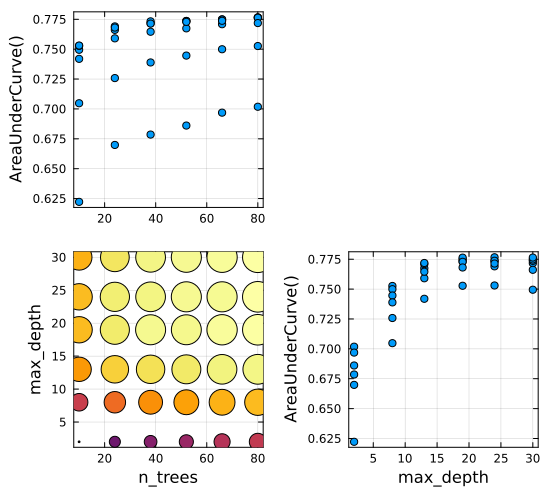

In [92]:
plot(mach)

Inspect results of tuning. AUC was rising with increasing number of trees; stabilises around 60 trees: the more trees in each random forest, the higher the chance that one with good predictive power will be created. Optimal value of `max_depth` is close to 25: deeper models are overfitted, but smaller are underfitted.

What is the best model?

In [93]:
best_model = fitted_params(mach).best_model

RandomForestClassifier(
  max_depth = 24, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 80, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = MersenneTwister(42, (0, 46353388, 46352386, 882, 0, 6)))

Compare tuned model performance to default forest:

In [96]:
evaluate(best_model, X_prepared, y, resampling=my_split, measure=my_measures)

PerformanceEvaluation object with these fields:
  model, measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows, resampling, repeats
Extract:
┌──────────────────────┬──────────────┬─────────────┬──────────┐
│ measure              │ operation    │ measurement │ per_fold │
├──────────────────────┼──────────────┼─────────────┼──────────┤
│ Accuracy()           │ predict_mode │ 0.9         │ [0.9]    │
│ AreaUnderCurve()     │ predict      │ 0.792       │ [0.792]  │
│ FScore(              │ predict_mode │ 0.397       │ [0.397]  │
│   beta = 1.0,        │              │             │          │
│   levels = nothing,  │              │             │          │
│   rev = nothing,     │              │             │          │
│   checks = true)     │              │             │          │
└──────────────────────┴──────────────┴─────────────┴──────────┘


In reality, all candidate models would be tuned and the best model from each compared on the holdout data, but this is computationally intensive.

Now, predict some `y` values:

In [98]:
predict_mode(mach, X_prepared[1:10, :])

10-element CategoricalArrays.CategoricalArray{String3,1,UInt32}:
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")
 String3("no")

To deploy the model, the `save` function can be used.